In [1]:
using Plots
using LinearAlgebra
using Parameters
using MyLibrary

In [2]:
module My

using Parameters 

@with_kw struct PhysicalParam{T} @deftype Float64
    ħc = 197.
    mc² = 938.
    
    Z::Int64 = 8
    N::Int64 = Z
    A::Int64 = Z + N
    
    t₀ = -1800
    t₃ = 12871
    α = 1/3
    
    Nr::Int64 = 100
    Δr = 0.1
    rs::T = range(Δr, Nr*Δr, length=Nr)
end

@with_kw struct QuantumNumbers @deftype Int64
    l = 0
    j = 1
    q = 1
end

@with_kw struct Densities
    ρ::Vector{Float64}
    τ::Vector{Float64} = similar(ρ)
end

@with_kw struct SingleParticleStates 
    nstates::Int64
    spEs::Vector{Float64}; @assert length(spEs) === nstates
    qnums::Vector{QuantumNumbers} ; @assert length(qnums) === nstates
    wfs::Matrix{Float64}; @assert size(wfs, 2) === nstates
    occ::Vector{Float64}; @assert length(occ) === nstates
end

end # module My

Main.My

In [3]:
param = My.PhysicalParam()

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}
  ħc: Float64 197.0
  mc²: Float64 938.0
  Z: Int64 8
  N: Int64 8
  A: Int64 16
  t₀: Float64 -1800.0
  t₃: Float64 12871.0
  α: Float64 0.3333333333333333
  Nr: Int64 100
  Δr: Float64 0.1
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}


In [4]:
function initial_density(param)
    @unpack A, rs = param
    
    r₀ = 1.2
    R = r₀*A^(1/3)
    a = 0.67
    ρ₀ = 3/(4π*r₀^3)
    
    ρ = similar(rs)
    @. ρ = ρ₀/(1 + exp((rs - R)/a))
    
    return My.Densities(ρ=ρ)
end

function test_initial_density(param)
    @unpack rs = param
    @time dens = initial_density(param)
    @time @unpack ρ = dens
    plot(rs, ρ)
end

test_initial_density (generic function with 1 method)

  0.000008 seconds (2 allocations: 1.750 KiB)
  0.000000 seconds


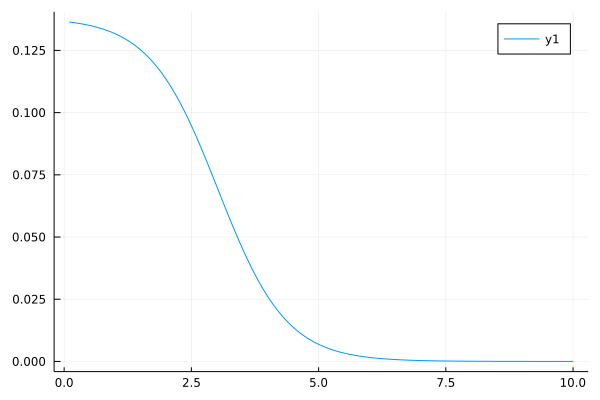

In [5]:
test_initial_density(param)

In [6]:
function calc_potential!(vpot, param, dens)
    @unpack ħc, mc², t₀, t₃, α, rs = param 
    @unpack ρ = dens
    
    @. vpot  = (3/4)*t₀*ρ + (α+2)/16*t₃*ρ^(α+1)
    @. vpot *= 2mc²/ħc^2
end

function test_calc_potential(param)
    @unpack ħc, mc², rs, Nr = param 
    dens = initial_density(param)
    
    vpot = similar(rs)
    @time calc_potential!(vpot, param, dens)
    
    plot(rs, vpot)
end

test_calc_potential (generic function with 1 method)

  0.000004 seconds


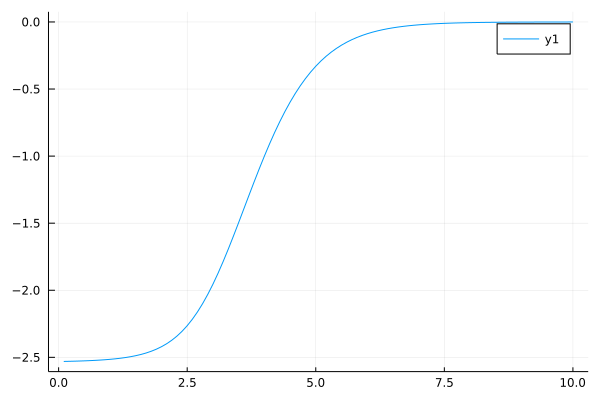

In [7]:
test_calc_potential(param)

In [8]:
function make_Hamiltonian(param, vpot, l)
    @unpack Nr, Δr, rs = param
    
    dv = similar(rs)
    @. dv = 2/Δr^2 + l*(l+1)/rs^2 + vpot 
    
    ev = fill(-1/Δr^2, Nr-1)
    
    Hmat = SymTridiagonal(dv, ev)
    
    return Hmat
end

function make_Hamiltonian!(dv, ev, param, vpot, l)
    @unpack Nr, Δr, rs = param
    
    @. dv = 2/Δr^2 + l*(l+1)/rs^2 + vpot 
    @. ev = -1/Δr^2
    
    return SymTridiagonal(dv, ev)
end


function test_make_Hamiltonian(param, l)
    @unpack Nr, rs = param
    vpot = @. rs^2
    
    dv = zeros(Float64, Nr  )
    ev = zeros(Float64, Nr-1)
    @time Hmat = make_Hamiltonian!(dv, ev, param, vpot, l)
    @time eigvals(Hmat)[1:10] ./2
end

test_make_Hamiltonian (generic function with 1 method)

In [9]:
test_make_Hamiltonian(param, 0)

  0.000003 seconds
  0.000253 seconds (6 allocations: 3.906 KiB)


10-element Vector{Float64}:
  1.4984357366699579
  3.49216962135222
  5.480870301381523
  7.464518486063689
  9.44309463646255
 11.416578960086351
 13.384951405415446
 15.348191656263882
 17.306279125969944
 19.259192951407556

In [10]:
function initial_states!(vpot, dv, ev, param, dens; Emax=0, lmax=5, nstates_max=100)
    @unpack ħc, mc², Nr, Δr, rs = param
    
    spEs = zeros(Float64, nstates_max)
    qnums = Vector{My.QuantumNumbers}(undef, nstates_max)
    wfs = zeros(Float64, Nr, nstates_max)
    occ = zeros(Float64, nstates_max)
    
    vpot = similar(rs)
    istate = 0
    for l in 0:lmax
        qnum = My.QuantumNumbers(l=l)
        calc_potential!(vpot, param, dens)
        Hmat = make_Hamiltonian!(dv, ev, param, vpot, l)
        
        vals, vecs = eigen(Hmat)
        
        # normalization
        @. vals *= ħc^2/2mc²
        @. vecs /= sqrt(Δr)
        
        n = length(vals[vals .< Emax])
        @views for i in 1:n
            istate += 1
            wfs[:, istate] = vecs[:,i]
            spEs[istate] = vals[i]
            qnums[istate] = qnum
        end
    end
    
    states = My.SingleParticleStates(
        nstates=istate,
        spEs=spEs[1:istate], 
        qnums=qnums[1:istate], 
        wfs=wfs[:,1:istate], 
        occ=occ[1:istate])
    
    return states
end

function sort_states!(states)
    @unpack spEs, qnums, wfs = states
    p = sortperm(spEs)
    wfs[:] = wfs[:,p]
    spEs[:] = spEs[p]
    qnums[:] = qnums[p]
    return 
end

function calc_occ!(states, param)
    @unpack A = param
    @unpack nstates, qnums, occ = states
    fill!(occ, 0)
    
    n = 0
    for i in 1:nstates
        @unpack l = qnums[i]
        if n + 4(2l+1) ≤ A 
            occ[i] = 1
            n += 4(2l+1)
        elseif n < A 
            occ[i] = (A - n)/4(2l+1)
        end
    end
    @assert n == A
    
    return 
end

function show_states(states)
    @unpack nstates, spEs, qnums, occ = states
    for i in 1:nstates
        println("i = $i: ")
        @show spEs[i] qnums[i] occ[i]
        println("")
    end
end

function test_initial_states!(param)
    @unpack Nr, rs = param
    dens = initial_density(param)
    
    vpot = zeros(Float64, Nr)
    dv   = zeros(Float64, Nr)
    ev   = zeros(Float64, Nr-1)
    @time states = initial_states!(vpot, dv, ev, param, dens)
    @time sort_states!(states)
    @time calc_occ!(states, param)
    
    show_states(states)
end

test_initial_states! (generic function with 1 method)

In [11]:
test_initial_states!(param)

  0.004161 seconds (100 allocations: 723.609 KiB)
  0.024097 seconds (16.88 k allocations: 1021.604 KiB, 99.88% compilation time)
  0.000001 seconds
i = 1: 
spEs[i] = -37.54576204592733
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 2: 
spEs[i] = -25.133125120743472
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 3: 
spEs[i] = -11.85888701654226
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1

occ[i] = 0.0

i = 4: 
spEs[i] = -10.547651208487943
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 0.0

i = 5: 
spEs[i] = -0.2693288027252988
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1

occ[i] = 0.0



In [12]:
function first_deriv!(dψ, param, ψ)
    @unpack Nr, Δr, rs = param
    
    dψ[1] = ψ[2]/2Δr
    for ir in 2:Nr-1
        dψ[ir] = (ψ[ir+1] - ψ[ir-1])/2Δr
    end
    dψ[Nr] = -ψ[Nr-1]/2Δr
    
    return 
end

function calc_density!(dens, dψ, param, states)
    @unpack rs = param
    @unpack nstates, qnums, wfs, occ = states
    @unpack ρ, τ = dens
    
    fill!(ρ, 0)
    fill!(τ, 0)
    for i in 1:nstates
        @unpack l = qnums[i]
        @views ψ = wfs[:,i]
        first_deriv!(dψ, param, ψ)
        
        @. ρ += occ[i] * 4(2l+1)/4π * (ψ/rs)^2
        @. τ += occ[i] * 4(2l+1)/4π * (dψ/rs - ψ/(rs*rs))*(dψ/rs - ψ/(rs*rs))
        @. τ += occ[i] * 4(2l+1)/4π * l*(l+1)*(ψ/rs^2)^2
    end
end

function test_calc_density(param)
    @unpack rs, Nr = param
    
    p = plot()
    
    dens = initial_density(param)
    plot!(p, rs, dens.ρ; label="ρ₀")
    
    vpot = zeros(Float64, Nr)
    dv   = zeros(Float64, Nr)
    ev   = zeros(Float64, Nr-1)
    dψ  = zeros(Float64, Nr)
    
    states = initial_states!(vpot, dv, ev, param, dens)
    sort_states!(states)
    calc_occ!(states, param)
    
    @time calc_density!(dens, dψ, param, states)
    
    plot!(p, rs, dens.ρ; label="ρ")
    plot!(p, rs, dens.τ; label="τ")
    display(p)
    
end

test_calc_density (generic function with 1 method)

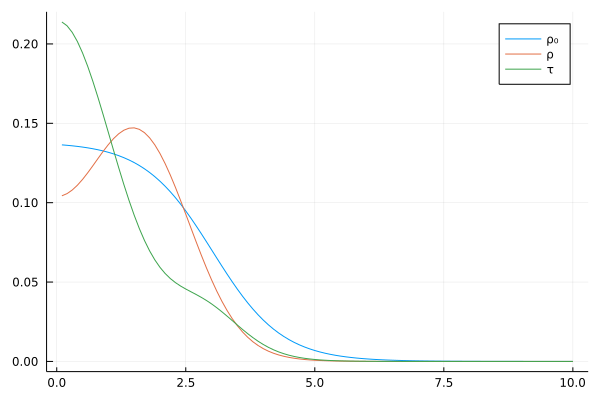

  0.000031 seconds


In [13]:
test_calc_density(param)

In [14]:
function calc_norm(param, ψ)
    @unpack Δr = param
    sqrt(dot(ψ, ψ)*Δr)
end

function calc_sp_energy(param, Hmat, ψ)
    @unpack ħc, mc² = param
    dot(ψ, Hmat, ψ)/dot(ψ, ψ) * (ħc^2/2mc²)
end

function calc_total_energy(param, dens)
    @unpack ħc, mc², t₀, t₃, α, Δr, Nr, rs = param 
    @unpack ρ, τ = dens
    
    ε = zeros(Float64, Nr)
    @. ε += ħc^2/2mc²*τ
    @. ε += (3t₀/8)*ρ^2 + (t₃/16)*ρ^(α+2)
    
    return sum((@. 4π*rs^2 * ε)) * Δr
end

function calc_total_energy2(param, dens, states)
    @unpack ħc, mc², t₀, t₃, α, Δr, Nr, rs = param 
    @unpack ρ, τ = dens
    @unpack nstates, spEs, qnums, occ = states
    
    ε = zeros(Float64, Nr)
    @. ε += ħc^2/4mc²*τ
    @. ε += -α/32 * t₃ * ρ^(α+2)
    
    E = sum((@. 4π*rs^2*ε)) * Δr
    
    for i in 1:nstates
        @unpack l = qnums[i]
        E += occ[i] * 4(2l+1) * 0.5spEs[i]
    end
    
    return E
end

calc_total_energy2 (generic function with 1 method)

In [15]:
function gram_schmidt!(param, states)
    @unpack Δr = param
    @unpack nstates, qnums, wfs = states
    
    for i in 1:nstates
        for j in 1:i-1
            if qnums[i] !== qnums[j] continue end
            
            @views wfs[:,i] .-= wfs[:,j] .* (dot(wfs[:,j], wfs[:,i])*Δr)
        end
        @views wfs[:,i] ./= calc_norm(param, wfs[:,i])
    end
end

function HF_calc_with_imaginary_time(param; Δt=0.1, iter_max=20)
    @unpack Nr, Δr = param
    
    dens = initial_density(param)
    
    vpot = zeros(Float64, Nr)
    dv   = zeros(Float64, Nr)
    ev   = zeros(Float64, Nr-1)
    dψ  = zeros(Float64, Nr)
    
    states = initial_states!(vpot, dv, ev, param, dens)
    sort_states!(states)
    calc_occ!(states, param)
    calc_density!(dens, dψ, param, states)
    
    @unpack nstates, spEs, qnums, wfs, occ = states
    
    @time for iter in 1:iter_max
        calc_potential!(vpot, param, dens)
        
        for i in 1:nstates
            @unpack l = qnums[i]
            Hmat = make_Hamiltonian!(dv, ev, param, vpot, l)
            
            @views wfs[:,i] = (I - 0.5Δt*Hmat)*wfs[:,i]
            @views wfs[:,i] = (I + 0.5Δt*Hmat)\wfs[:,i]
            
            for j in 1:i-1
                if qnums[i] !== qnums[j] continue end

                @views wfs[:,i] .-= wfs[:,j] .* (dot(wfs[:,j], wfs[:,i])*Δr)
            end
            @views wfs[:,i] ./= calc_norm(param, wfs[:,i])
            @views spEs[i] = calc_sp_energy(param, Hmat, wfs[:,i])
        end
            
        sort_states!(states)
        calc_occ!(states, param)
        calc_density!(dens, dψ, param, states)
    end
    
    show_states(states)
    @show calc_total_energy(param, dens)
    @show calc_total_energy2(param, dens, states)
    
    return dens, states
end
        
                

HF_calc_with_imaginary_time (generic function with 1 method)

In [22]:
HF_calc_with_imaginary_time(param; iter_max=20)
;

  0.003649 seconds (1.40 k allocations: 1.199 MiB)
i = 1: 
spEs[i] = -36.03982375008466
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 2: 
spEs[i] = -20.908586370860935
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 3: 
spEs[i] = -4.00405789821797
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1

occ[i] = 0.0

i = 4: 
spEs[i] = -1.6250110424778856
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 0.0

i = 5: 
spEs[i] = 4.750368949711177
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1

occ[i] = 0.0

calc_total_energy(param, dens) = -189.18201361251263
calc_total_energy2(param, dens, states) = -189.13825524272616
